In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [6]:
# Read the the dataset
df_train = pd.read_csv('training.csv')
df = df_train.copy()
df.head()

,id,latitude,longitude,width,height,size,name,description,caption,good
0,1,45,16,604,453,31,454 1659,NaN,NaN,1
1,2,21,-87,720,534,43,2068 483,687 1182 1309 2068 2107 78 89 453 1905 712 120...,830 2112 1914 792 814 1386 474 2146 1591 194 5...,0
2,3,38,-97,720,540,71,802,NaN,NaN,0
3,4,38,-122,604,453,24,NaN,924 1914 671 853 193 51 744 1437 1245 563 1410...,665 2040 792 1056 226 248 1612 1920 617 1365 1...,0
4,5,-29,24,720,540,13,1766 20,NaN,181 891 22 2123 2107 523 2080 683 1640 166 109...,0


In [7]:
# Look for null values
df.isnull().sum()

id                 0
latitude           0
longitude          0
width              0
height             0
size               0
name            4798
description    27564
caption        11807
good               0
dtype: int64

In [8]:
# Look for the different types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40262 entries, 0 to 40261
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           40262 non-null  int64 
 1   latitude     40262 non-null  int64 
 2   longitude    40262 non-null  int64 
 3   width        40262 non-null  int64 
 4   height       40262 non-null  int64 
 5   size         40262 non-null  int64 
 6   name         35464 non-null  object
 7   description  12698 non-null  object
 8   caption      28455 non-null  object
 9   good         40262 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 3.1+ MB


In [9]:
# Define the features and the target columns
inputs = list(df.columns)[1:-1]
target = 'good'

In [10]:
# Define the features and the target data
X = df[inputs]
y = df[target]

In [11]:
# Get the numerical and the categorical columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes('object').columns.tolist()

In [12]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Replace the categorical columns with the most the frequent one
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')

imp.fit(df[categorical_cols])

X_train[categorical_cols] = imp.transform(X_train[categorical_cols])
X_test[categorical_cols] = imp.transform(X_test[categorical_cols])

In [14]:
# Count the occurence for each value in the categorical columns
X_train[categorical_cols].value_counts()

name            description            caption                                                
1237 2002       1237 2002              1905                                                       721
2068            1237 2002              1905                                                        79
1207            1237 2002              1905                                                        46
1559            1237 2002              1905                                                        44
432 1560        1237 2002              1905                                                        39
                                                                                                 ... 
1412 483        1237 2002              2107 815 51 348 271 1944 1544 1984 813                       1
1411 1048       643 968 1976 250 1950  830 2019 1899 1118 1096 1905 1955 2054 949 817 784 1368      1
1410 745 1242   1749 745 1242          1419 2107 1905 427 829 2039                       

We can see that there are a lot of occurences for some values and others have few so let's remove the categorical values for now

In [ ]:
# Delete the categorical values from both train and test data
X_train.drop(categorical_cols, axis=1, inplace=True)
X_test.drop(categorical_cols, axis=1, inplace=True)

In [16]:
X_train.head()

,latitude,longitude,width,height,size
39565,36,-122,720,540,31
30033,44,-73,320,240,11
26360,51,9,604,453,58
38374,32,-86,720,480,12
33631,35,105,604,453,31


## Model Training and tuning

Let's start with a decision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
model = DecisionTreeClassifier(random_state=42)

In [19]:
%%time
model.fit(X_train, y_train)

CPU times: user 72.9 ms, sys: 1.48 ms, total: 74.3 ms
Wall time: 73.1 ms


DecisionTreeClassifier(random_state=42)

In [20]:
train_preds = model.predict(X_train)

In [21]:
# Check the accuracy score to see how our model will perform on the train data
accuracy_score(y_train, train_preds)

0.9667099165894346

In [22]:
# Check the score on the test data
model.score(X_test, y_test)

0.6814931888311884

We can see that there is a big difference between the score of the training set and the test set. The model has perfectely learned the train set and can't do well on the test set. There is overfiting

Let's retrain our model by specifying some parameters for the decision tree

In [23]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [24]:
# Let's check the score on the training set
model.score(X_train, y_train)

0.7397590361445783

In [25]:
# Let's check the score on the test set
model.score(X_test, y_test)

0.7374125084669225

Both score are close to each other. That's a great news. There is no overfiting anymore. Let's try to improve the model prediction power

In [26]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_test, y_test)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [27]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 990 ms, sys: 0 ns, total: 990 ms
Wall time: 989 ms


Let's plot the errors

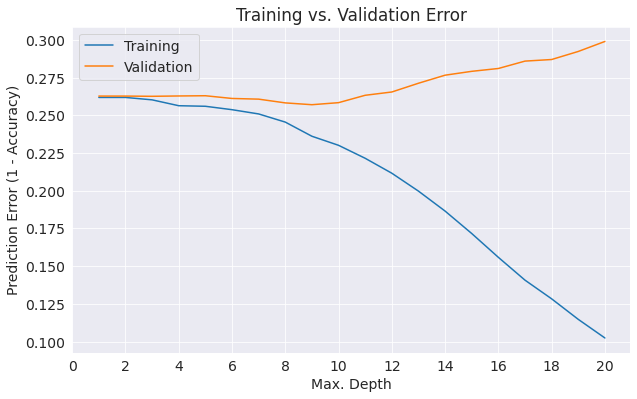

In [28]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

It seems like the best max depth for our model is around 2 so let's retrain our model with a max_depth of 2

In [53]:
model = DecisionTreeClassifier(max_depth=2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7372619853992625

With the results above, we saw the best score we can achieve with the decision tree. Let's now try to train our model with the random forest algorithm

In [54]:
from sklearn.ensemble import RandomForestClassifier

Let's train and check the score on the train data

In [56]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

model.fit(X_train, y_train)

model.score(X_train, y_train)

0.9667099165894346

In [57]:
# Let's look for the score on the test dataset
model.score(X_test, y_test)

0.7263490629939038

The behavior of our random forest model is like the the decision tree's. Let's tune it with different parameters

In [58]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
    return model.score(X_train, y_train), model.score(X_test, y_test)

In [69]:
test_params(max_depth=8)

(0.7592585727525487, 0.7445623541807782)

After trying different parameters and different values. Let's define the parameters of our final random forest model

In [83]:
model = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=20, max_depth=10)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.7803521779425394

In [81]:
model.score(X_test, y_test)

0.7475728155339806

We have a pretty good model that can be used on unseen data. Let's try to see if we can improve it with another algorithm

In [95]:
from xgboost import XGBClassifier

In [98]:
model = XGBClassifier()
model.fit(X_train, y_train)
model.score(X_train, y_train)

[14:52:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.811306765523633

In [107]:
model.score(X_test, y_test)

0.7490780462105818

We weren't able to improve our test score on the test dataset so we decide to keep the final random forest model as the model to use if we had to put the model into production. We decide so because the train and test score are close to each  other so there is no overfitting. 

In [ ]:
!pip install jovian --quiet

In [101]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit()

In [ ]:
jovian.submit(assignment="zerotogbms-project")